In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random

import h5py
from IPython.utils import io

In [3]:
%matplotlib notebook

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('../../../../nadavp/new_trap/Tools/')
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

In [6]:
from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux
gfw = GravityFramework.GravityFramework()

In [7]:
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities import *

In [8]:
dist = 11.4
z_sep = -10
y_offset = 4.9
test = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"z",10e-6, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                     alpha=1e8, bead_size=3.8e-6)

Your choice of lambda is not existing
Taking 1.00e-05 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.10e-05 is selected
A height of -1.00e-05 is selected


<IPython.core.display.Javascript object>


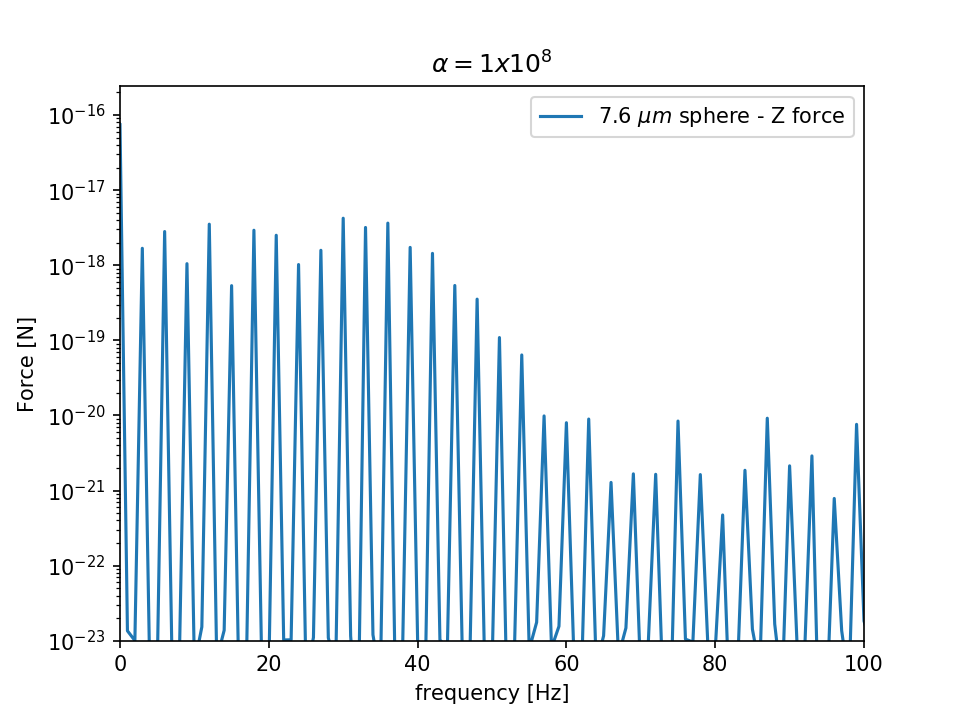

Z force [N] at 36Hz.: [3.63707654e-18]


In [160]:
def fft_norm(N, fsamp):
    "Factor to normalize FFT to ASD units"
    return np.sqrt(2 / (N * fsamp))
scale = np.sqrt(2)*fft_norm(5000, 5000)

_,ax = plt.subplots()
x = np.array(list(test[1])*1)*1.85/1.55
x10 = np.array(list(test[1])*10)*1.85/1.55
# x -= np.mean(x)
fft = np.abs(np.fft.rfft(x))*scale
angles = np.angle(np.fft.rfft(x))
# fft2 = np.abs(np.fft.rfft(x2))*scale
freq = np.fft.rfftfreq(len(x), d=1./5000)
ax.semilogy(freq, fft, label='7.6 $\mu m$ sphere - Z force')
# ax.semilogy(freqs_signal,np.array(amps)/scale2, '.')
# ax.semilogy(freq, fft2, label='7.6 $\mu m$ sphere - Z force', alpha=0.5)
ax.set(xlim=(0,100), ylim=(1e-23,None), xlabel='frequency [Hz]', ylabel='Force [N]', title=r'$\alpha=1x10^{8}$')
ax.legend()
print('Z force [N] at 36Hz.:', fft[freq==36])
force_36 = fft[freq==36]

In [161]:
scale2 = 1e17
x_phase = (x10)*scale2

In [162]:
##mock bdf with scaled Z signal model
bdf_ = load_dir(dirname='/data/new_trap/20200316/Bead1/Shaking/Shaking368/', 
                         file_prefix='Shaking0', start_file=0, max_file=1)[0]
bdf_.z2 = x_phase
print(x_phase.shape)

No laser power data
100  files in folder
1  files loaded
(50000,)


In [163]:
fit_kwargs = {'A': 0.3, 'f': 3, 'phi': np.pi,
              'error_A': 0.1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [0.0001, 1000],
              'print_level': 0, 'fix_A': False, 'fix_f': True, 'fix_phi': False}
A,e,m1 = gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, bandwidth=2, decimate=10, **fit_kwargs)

***************************************************
Z2-amplitude:  1.86e-01
reduced chi2:  0.0002494594009692099


/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [164]:
freqs_signal = 3*np.arange(1,22)
amps = []
phases = []
for freq_ in freqs_signal:
    fit_kwargs['f'] = freq_
    A, _, m1 = gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, decimate=10, bandwidth=2, **fit_kwargs)
    amps.append(A)
    phases.append(m1.values[2])

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


***************************************************
Z2-amplitude:  1.86e-01
reduced chi2:  0.0002494594009692099
***************************************************
Z2-amplitude:  2.67e-01
reduced chi2:  9.948500842051265e-06
***************************************************
Z2-amplitude:  1.07e-01
reduced chi2:  6.65196601676351e-07
***************************************************
Z2-amplitude:  3.52e-01
reduced chi2:  1.5568311751598567e-06
***************************************************
Z2-amplitude:  5.34e-02
reduced chi2:  2.8758291476503144e-07
***************************************************
Z2-amplitude:  2.93e-01
reduced chi2:  1.0113594881841468e-06
***************************************************
Z2-amplitude:  2.51e-01
reduced chi2:  7.000411788203838e-07
***************************************************
Z2-amplitude:  1.02e-01
reduced chi2:  1.8187648127891072e-07
***************************************************
Z2-amplitude:  1.58e-01
reduced chi2:  4.

<IPython.core.display.Javascript object>


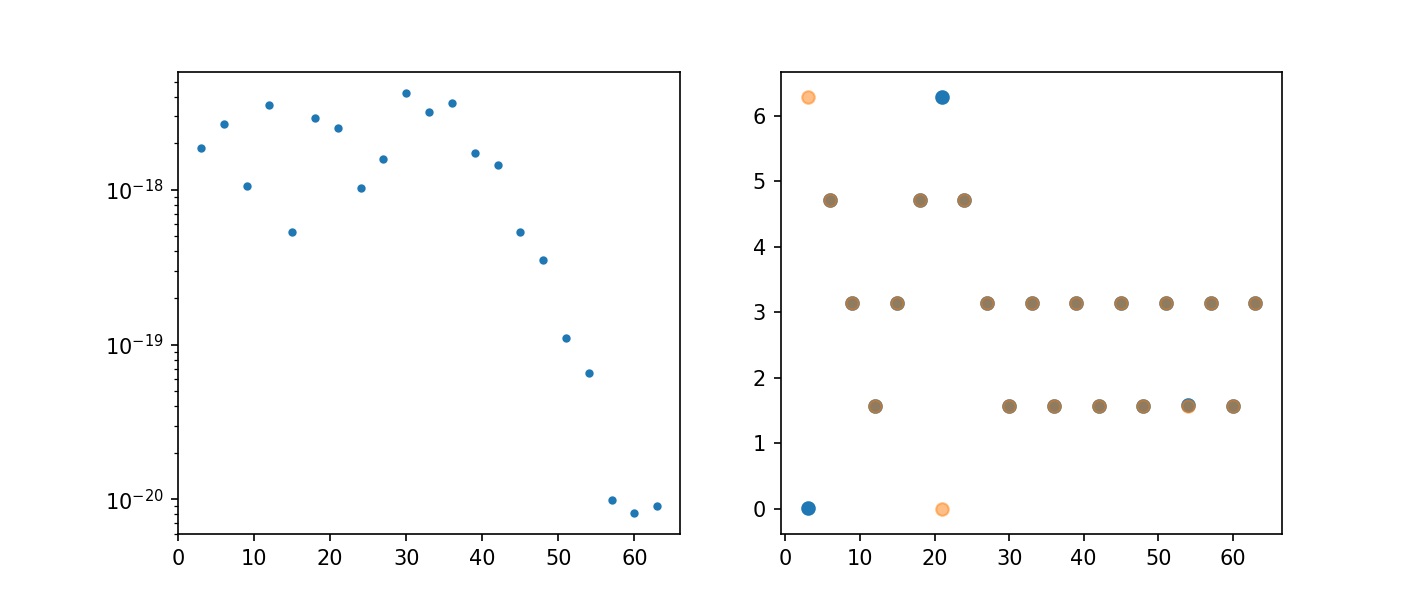

In [165]:
angles_signal = np.array([angles[freq==freq_] for freq_ in freqs_signal])
_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].semilogy(freqs_signal, np.array(amps)/scale2%(2*np.pi), '.')
ax[1].scatter(freqs_signal, phases)
ax[1].scatter(freqs_signal, (angles_signal+np.pi/2)%(2*np.pi), alpha=0.5)

In [22]:
def get_force(dist=11.4, lamb=100):
    
    freqs_signal = 3*np.arange(1,22)
    z_sep = -10
    y_offset = 4.9
    test = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"z",lamb*1e-6, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                         alpha=1e8, bead_size=3.8e-6)

    scale = np.sqrt(2)*fft_norm(5000, 5000)
    x = np.array(list(test[1])*1)*1.85/1.55
    fft = np.abs(np.fft.rfft(x))*scale
    angles = np.angle(np.fft.rfft(x))
    freq = np.fft.rfftfreq(len(x), d=1./5000)

    forces_tmp = np.array([fft[freq==freq_] for freq_ in freqs_signal])
    
    return forces_tmp

def get_force_distances(lamb=100):
    forces = []
    for dist_ in np.arange(1,20, 0.1):
        forces.append(get_force(dist=dist_, lamb=lamb))
    return forces

In [40]:
fff = np.array(get_force_distances(lamb=100))
# fff2x = np.array(get_force_distances(lamb=3))

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.0e-06 for separation
Taking 8.5e-21 for height
Your choice o

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 5.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 5.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 5.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 5.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 5.0e-06 for separation
Taking 8.5e-21 for height
Your choice o

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 6.50e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 7.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 7.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 7.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is 

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 8.5e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 8.50e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 9.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 9.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 9.0e-06 for separation
Taking 8.5e-21 for height
Your choice o

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.0e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.1e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.10e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.1e-05 for separation
Taking 8.5e-21 for height
Your choice o

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.3e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.30e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.3e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.30e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.3e-05 for separation
Taking 8.5e-21 for height
Your choice o

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.6e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.55e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.6e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.55e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.6e-05 for separation
Taking 8.5e-21 for height
Your choice o

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.70e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.7e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.70e-05 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.8e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is 

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 2.0e-05 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 2.00e-05 is selected
A height of 8.47e-21 is selected


<IPython.core.display.Javascript object>


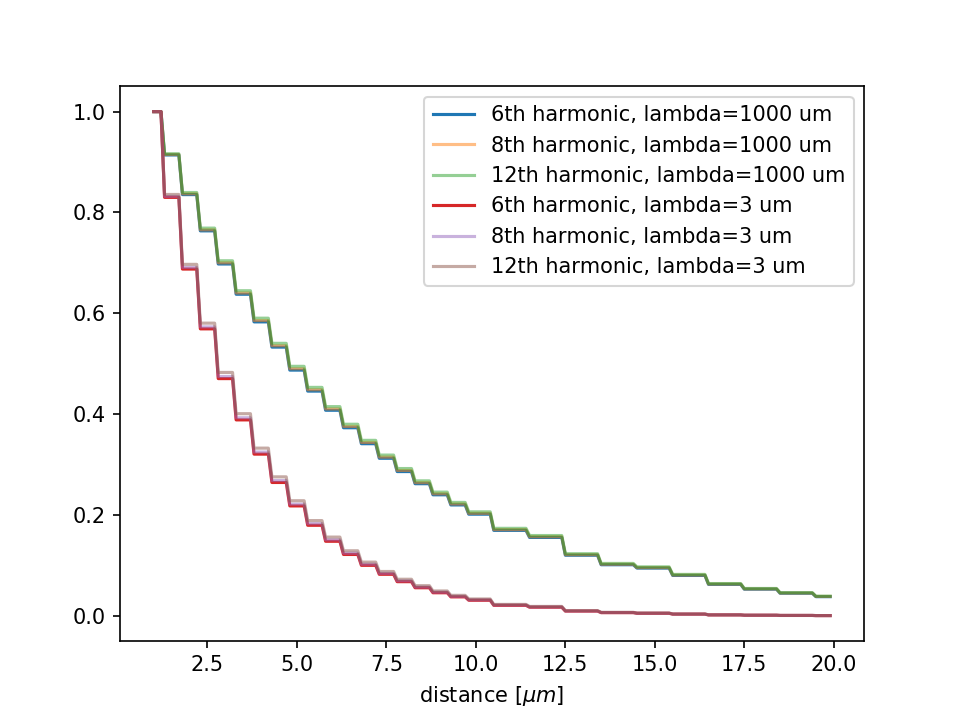

[Text(0.5, 0, 'distance [$\\mu m$]')]

In [17]:
_, ax = plt.subplots()
ax.plot(np.arange(1,20, 0.1), fff[:,6]/fff[0,6], label='6th harmonic, lambda=1000 um')
ax.plot(np.arange(1,20, 0.1), fff[:,8]/fff[0,8], alpha=0.5, label='8th harmonic, lambda=1000 um')
ax.plot(np.arange(1,20, 0.1), fff[:,12]/fff[0,12], alpha=0.5, label='12th harmonic, lambda=1000 um')

ax.plot(np.arange(1,20, 0.1), fff2[:,6]/fff2[0,6], label='6th harmonic, lambda=3 um')
ax.plot(np.arange(1,20, 0.1), fff2[:,8]/fff2[0,8], alpha=0.5, label='8th harmonic, lambda=3 um')
ax.plot(np.arange(1,20, 0.1), fff2[:,12]/fff2[0,12], alpha=0.5, label='12th harmonic, lambda=3 um')

ax.legend()

ax.set(xlabel='distance [$\mu m$]')

<IPython.core.display.Javascript object>


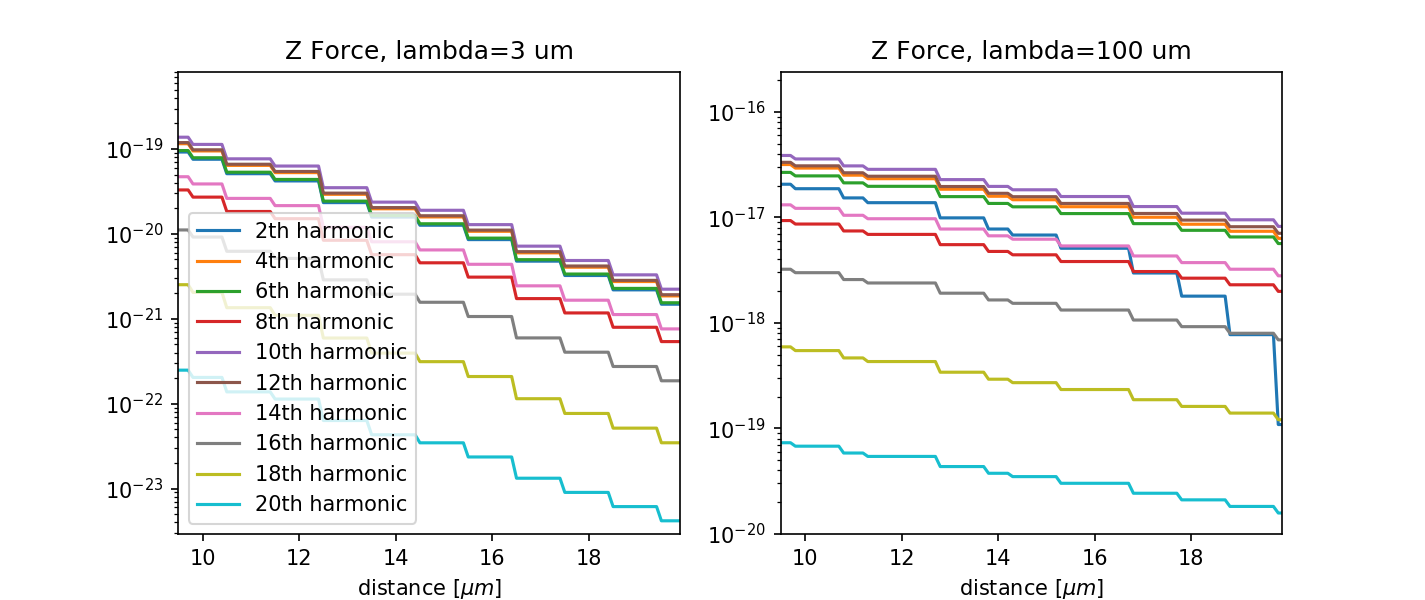

[Text(0.5, 0, 'distance [$\\mu m$]'), Text(0.5, 1.0, 'Z Force, lambda=100 um')]

In [58]:
_, ax = plt.subplots(1,2,figsize=(9.5,4), sharex=True)
[ax[0].semilogy(np.arange(1,20, 0.1), fff2[:,i], label=str(i+1)+'th harmonic') for i in range(1,21)[::2]]
[ax[1].semilogy(np.arange(1,20, 0.1), fff[:,i], label=str(i+1)+'th harmonic') for i in range(1,21)[::2]]

ax[0].legend()

ax[0].set(xlabel='distance [$\mu m$]', title='Z Force, lambda=3 um')
ax[1].set(xlabel='distance [$\mu m$]', title='Z Force, lambda=100 um')

<IPython.core.display.Javascript object>


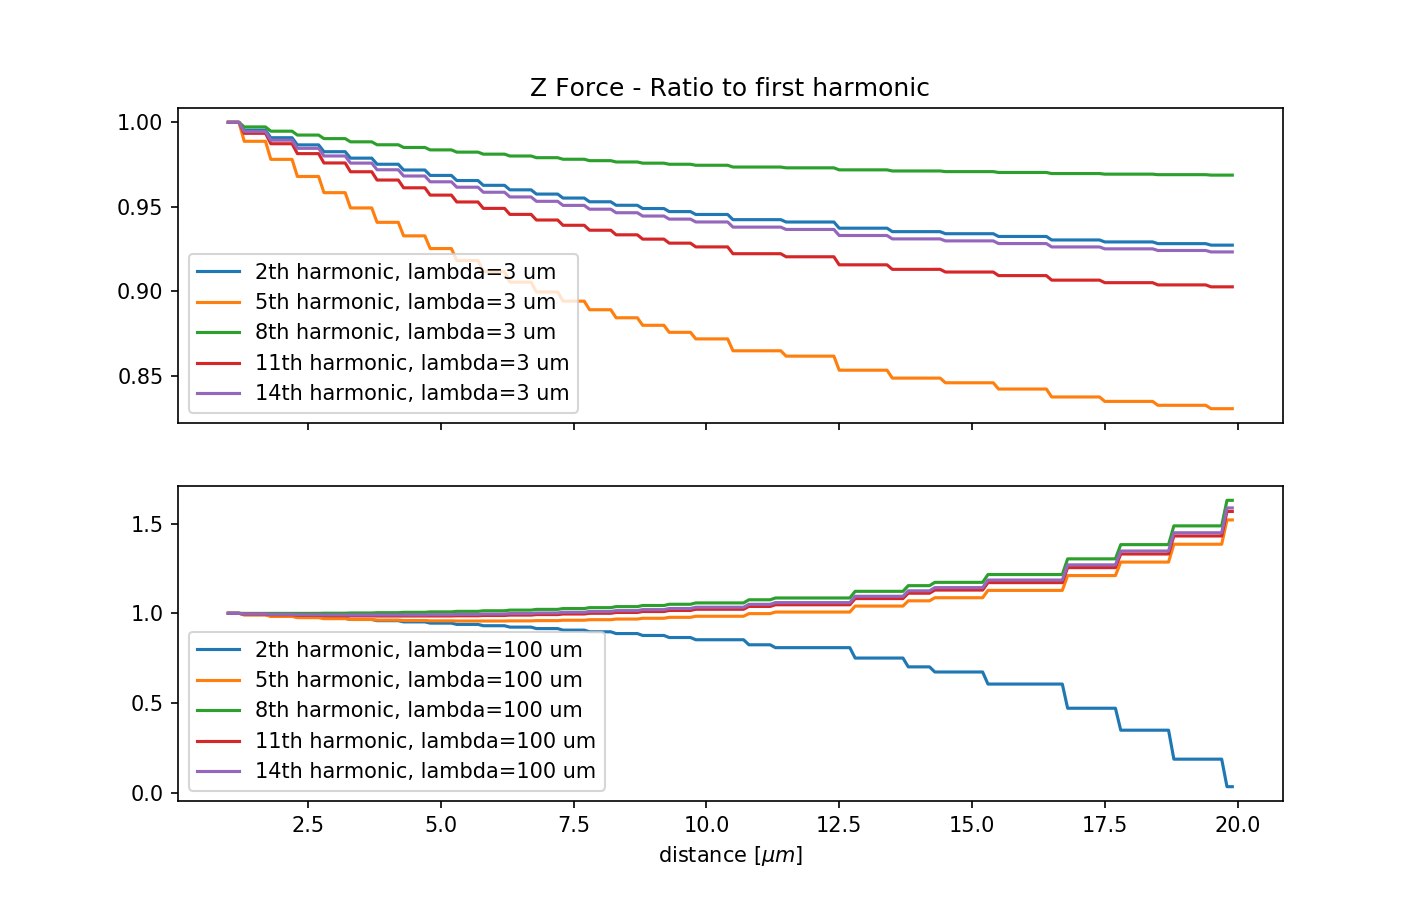

[Text(0.5, 0, 'distance [$\\mu m$]')]

In [59]:
_, ax = plt.subplots(2,1,figsize=(9.5,6), sharex=True)
[ax[0].plot(np.arange(1,20, 0.1), fff2[:,i]/fff2[:,0]/fff2[0,i]*fff2[0,0], label=str(i+1)+'th harmonic, lambda=3 um') for i in range(1,15)[::3]]
[ax[1].plot(np.arange(1,20, 0.1), fff[:,i]/fff[:,0]/fff[0,i]*fff[0,0], label=str(i+1)+'th harmonic, lambda=100 um') for i in range(1,15)[::3]]

ax[0].legend()
ax[1].legend()

ax[0].set(title='Z Force - Ratio to first harmonic')
ax[1].set(xlabel='distance [$\mu m$]')

In [82]:
index_14 = (np.arange(1,20, 0.1)<14.02)*(np.arange(1,20, 0.1)>13.95)
force_100 = fff[index_14,:].flatten()
force_6 = fff2[index_14,:].flatten()

<IPython.core.display.Javascript object>


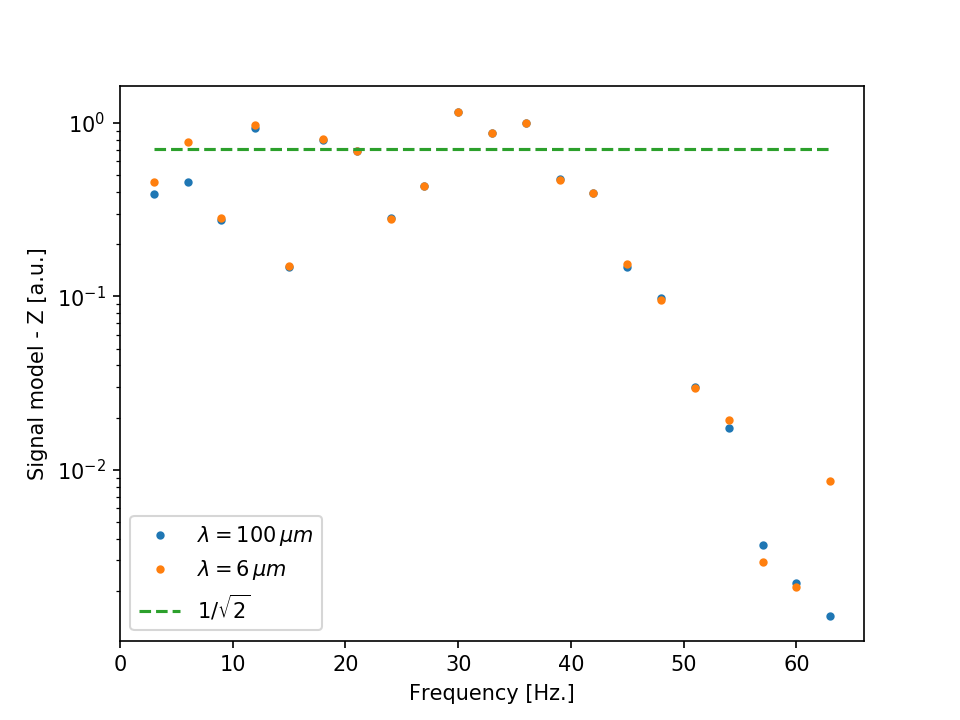

In [140]:
_,ax = plt.subplots()
ax.semilogy(np.arange(1,22)*3, force_100/force_100[11], '.', label=r'$\lambda=100\,\mu m$')
ax.semilogy(np.arange(1,22)*3, force_6/force_6[11], '.', label=r'$\lambda=6\,\mu m$')
ax.semilogy(np.arange(1,22)*3, np.arange(1,22)*0+1/np.sqrt(2), '--', label=r'1/$\sqrt{2}$')
ax.set(xlabel='Frequency [Hz.]', ylabel=r'Signal model - Z [a.u.]')
ax.legend()

In [114]:
harmonics_sen = [12, 11, 4, 6, 7,13,9,8]
signal = [force_100[harmonics_-1]/force_100[11] for harmonics_ in harmonics_sen]
sum_signal = np.array([sum(signal[:i+1]) for i in range(len(signal))])
b = 2
sum_backgrounds = np.array([b*(i+1) for i in range(len(signal))])

<IPython.core.display.Javascript object>


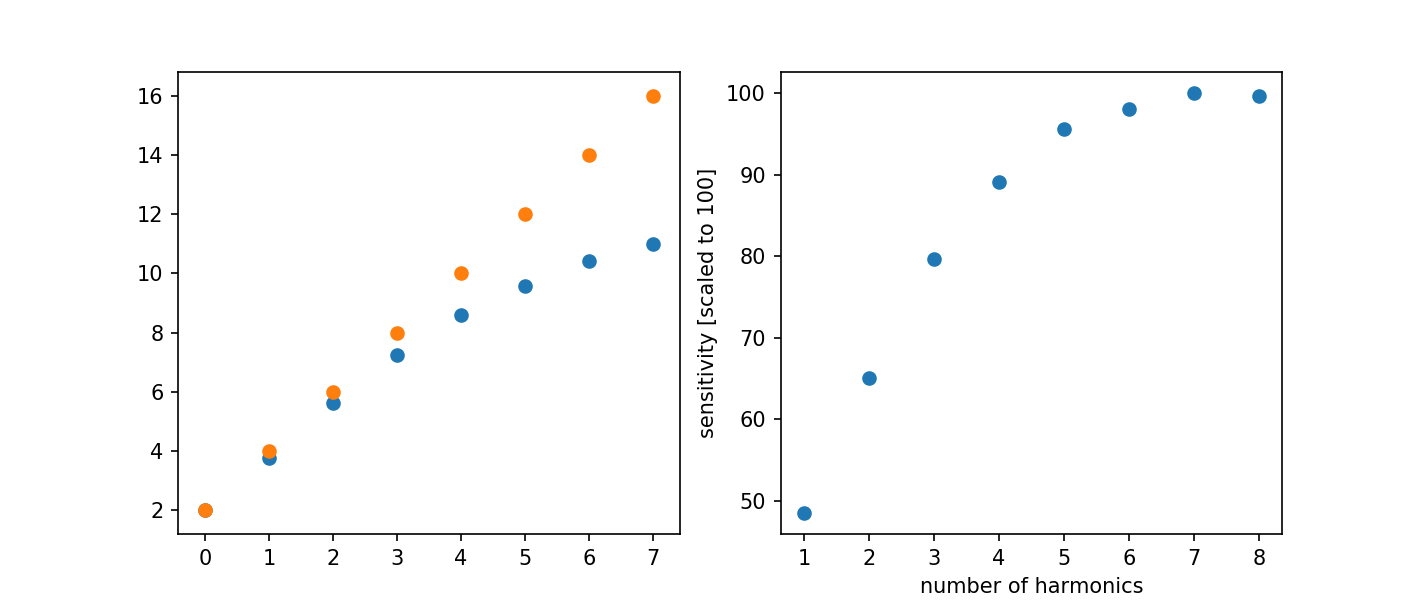

[Text(0, 0.5, 'sensitivity [scaled to 100]'),
 Text(0.5, 0, 'number of harmonics')]

In [145]:
_, ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].scatter(range(len(signal)), sum_signal*2)
ax[0].scatter(range(len(signal)), sum_backgrounds)
sens = sum_signal/np.sqrt(sum_backgrounds+sum_signal)
ax[1].scatter(np.arange(len(signal))+1, sens/np.max(sens)*100)
ax[1].set(xlabel='number of harmonics', ylabel='sensitivity [scaled to 100]')

### Including phase - Shaking378-3

In [146]:
bdf_discharge = load_dir(dirname='/data/new_trap/20200320/Bead1/Discharge/New_Discharge/',
                         start_file=0, max_file=1000)

No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
No laser power data
15  files in folder
15  files loaded


In [147]:
bdf_z = bdf_discharge[:5]
bdf_x = bdf_discharge[5:10]
bdf_y = bdf_discharge[10:]

freq = bdf_z[0].psd2('z')[0]
z_scale = bdf_z[0].psd2('z')[1][freq==71]
for bb in bdf_z:
    z_scale += bb.psd2('z')[1][freq==71]
z_scale /= len(bdf_z)

x_scale = bdf_x[0].psd2('x')[1][freq==71]
for bb in bdf_x:
    x_scale += bb.psd2('x')[1][freq==71]
x_scale /= len(bdf_x)

y_scale = bdf_y[0].psd2('y')[1][freq==71]
for bb in bdf_y:
    y_scale += bb.psd2('y')[1][freq==71]
y_scale /= len(bdf_y)

charges = 7
force = charges * 1.6e-19 * 20 / 8.6e-3 * 0.63 * np.sqrt(10) # in Newtons/sqrt(Hz)
z_scale = force/np.sqrt(z_scale)
x_scale = force/np.sqrt(x_scale)
y_scale = force/np.sqrt(y_scale)

In [148]:
## 1000 files of shaking data for nose floor
data_bdfs = load_dir(dirname='/data/new_trap/20200320/Bead1/Shaking/Shaking378/',
                         file_prefix='Shaking3', start_file=0, max_file=1000)
freq = data_bdfs[0].psd2('x')[0]
fftx1 = data_bdfs[0].psd2('x')[1]
ffty1 = data_bdfs[0].psd2('y')[1]
fftz1 = data_bdfs[0].psd2('z')[1]
for i in range(1,1000):
    fftx1 += data_bdfs[i].psd2('x')[1]
    fftz1 += data_bdfs[i].psd2('z')[1]
    ffty1 += data_bdfs[i].psd2('y')[1]
fftx1/=1000
ffty1/=1000
fftz1/=1000

10000  files in folder
1000  files loaded


<IPython.core.display.Javascript object>


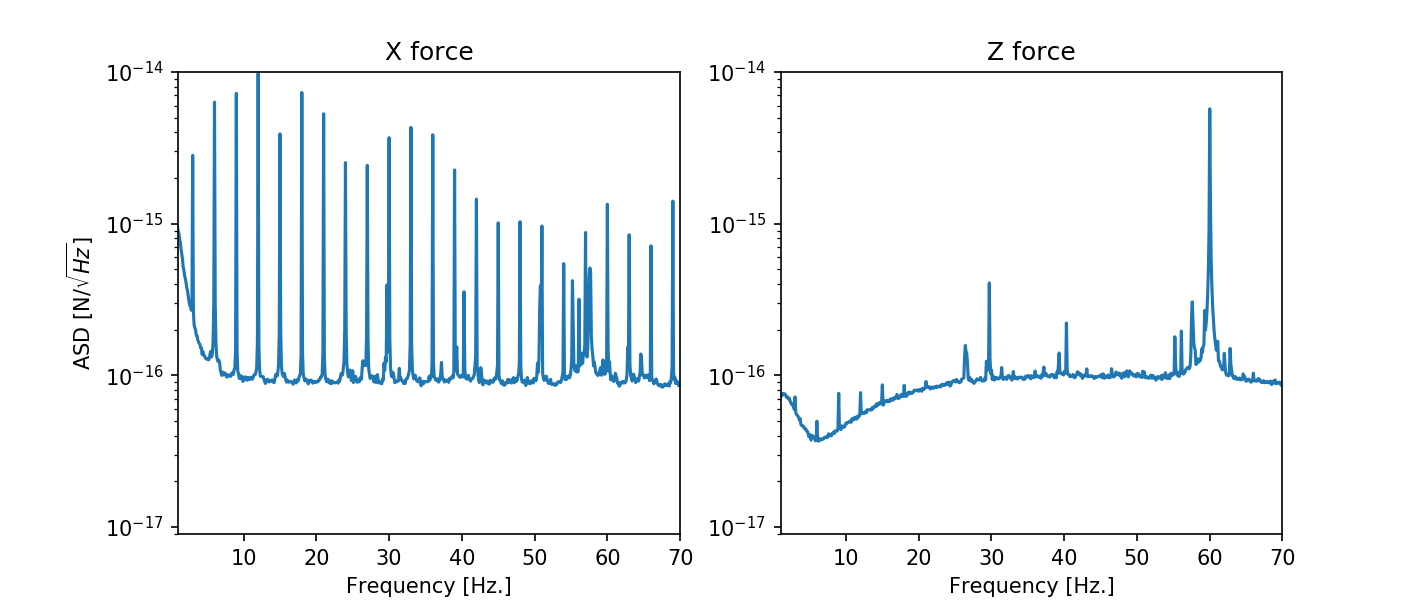

[1.21941716e-15] [3.38043053e-17]


In [149]:
_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].semilogy(freq, np.sqrt(fftx1)*x_scale)
ax[1].semilogy(freq, np.sqrt(fftz1)*z_scale)
ax[0].set(xlim=(1,70), ylim=(9e-18,1e-14), xlabel='Frequency [Hz.]', ylabel=r'ASD [N/$\sqrt{Hz}$]', title='X force')
_ = ax[1].set(xlim=(1,70), ylim=(9e-18,1e-14), xlabel='Frequency [Hz.]', title=r'Z force')
print(np.sqrt(fftx1[freq==36])*x_scale/np.sqrt(10), np.sqrt(fftz1[freq==36])*z_scale/np.sqrt(10))

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


<IPython.core.display.Javascript object>


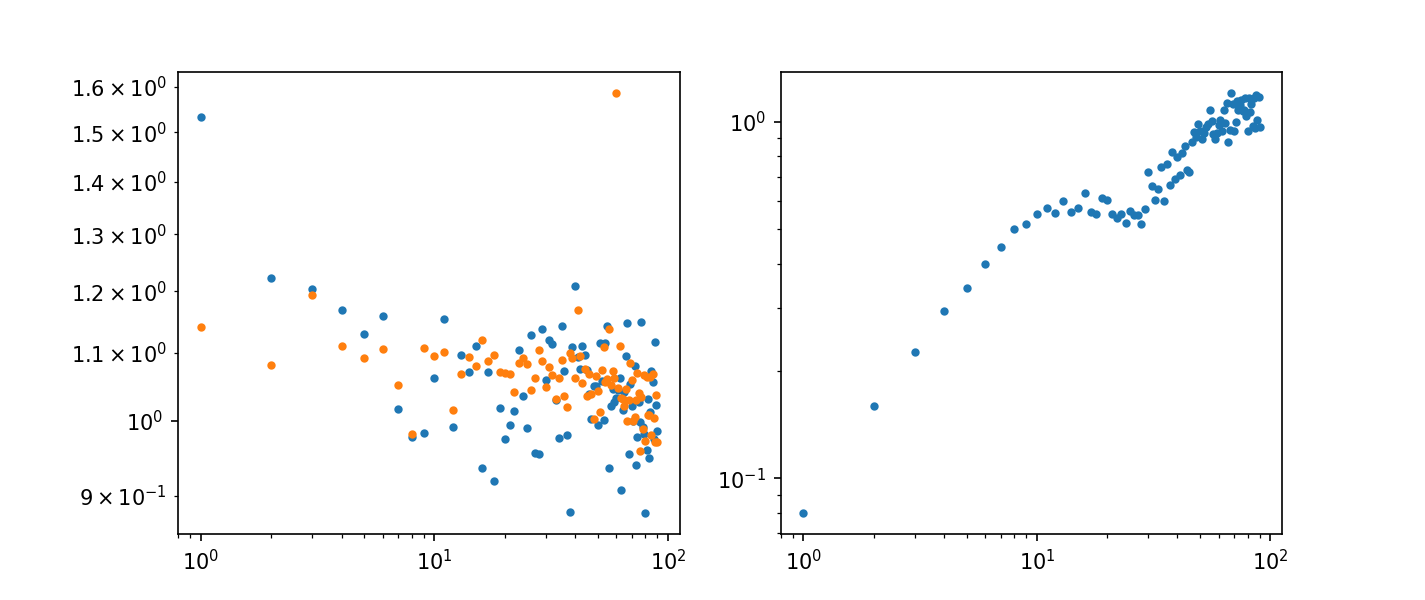

In [8]:
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_X_m300k_250s_1hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Y_m300k_250s_1hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Z_m300k_250s_1hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)
gfw.build_transfer_function([tf_x, tf_y, tf_z], base_freq=1, number_of_harmonics=90, scale_freq=71, plot=True)

In [13]:
fit_kwargs = {'A': 30, 'f': 36, 'phi': np.pi,
              'error_A': 0.1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [0.0001, 1000],
              'print_level': 0, 'fix_A': False, 'fix_f': True, 'fix_phi': False}
gfw.get_z_amplitude(bdf=tf_z, noise_rms=1, decimate=10, bandwidth=1, **fit_kwargs)[2].values

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


***************************************************
Z2-amplitude:  3.89e+01
reduced chi2:  267.9111284196778


<ValueView of Minuit at 26ce248>
  A: 38.93407200968503
  f: 36.0
  phi: 1.8428445259252597

In [67]:
tf_phase = []
for freq_ in freq_search:
    fit_kwargs['f'] = freq_
    tf_phase.append(gfw.get_z_amplitude(bdf=tf_z, noise_rms=1, decimate=10, bandwidth=1, **fit_kwargs)[2].values[2])

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


***************************************************
Z2-amplitude:  3.89e+01
reduced chi2:  267.9111284196778
***************************************************
Z2-amplitude:  3.32e+01
reduced chi2:  220.52278055038633
***************************************************
Z2-amplitude:  2.50e+01
reduced chi2:  117.17943806057056
***************************************************
Z2-amplitude:  2.83e+01
reduced chi2:  127.00368685937268
***************************************************
Z2-amplitude:  2.83e+01
reduced chi2:  150.52874246346585
***************************************************
Z2-amplitude:  3.52e+01
reduced chi2:  257.5361635762363
***************************************************
Z2-amplitude:  2.80e+01
reduced chi2:  237.9207034735624
***************************************************
Z2-amplitude:  2.65e+01
reduced chi2:  178.23592531081826


In [68]:
tf_angles = np.angle(np.fft.rfft(tf_z.z2))
tf_freq = np.fft.rfftfreq(len(tf_z.z2), d=1./5000)

In [69]:
freq_search = np.array([12, 11, 4, 6, 7,13,9,8])*3

In [70]:
tf_phase2 = []
for freq_ in range(1,80):
    tf_phase2.append(tf_angles[tf_freq==freq_])

In [71]:
freq_search = np.array([12, 11, 4, 6, 7,13,9,8])*3
tf_angles = np.angle(np.fft.rfft(np.array(list(tf_z.electrode_data[0])*10)))
tf_freq2 = np.fft.rfftfreq(50000, d=1./5000)
tf_phase3 = []
for freq_ in range(1,80):
    tf_phase3.append(tf_angles[tf_freq2==freq_])

In [72]:
phases_diff = (np.array(tf_phase3).flatten()-np.array(tf_phase2).flatten())%(2*np.pi)-2*np.pi
phases_diff2 = []
for pp in phases_diff:
    if pp<-4:
        phases_diff2.append(pp+2*np.pi)
    else:
        phases_diff2.append(pp)

<IPython.core.display.Javascript object>


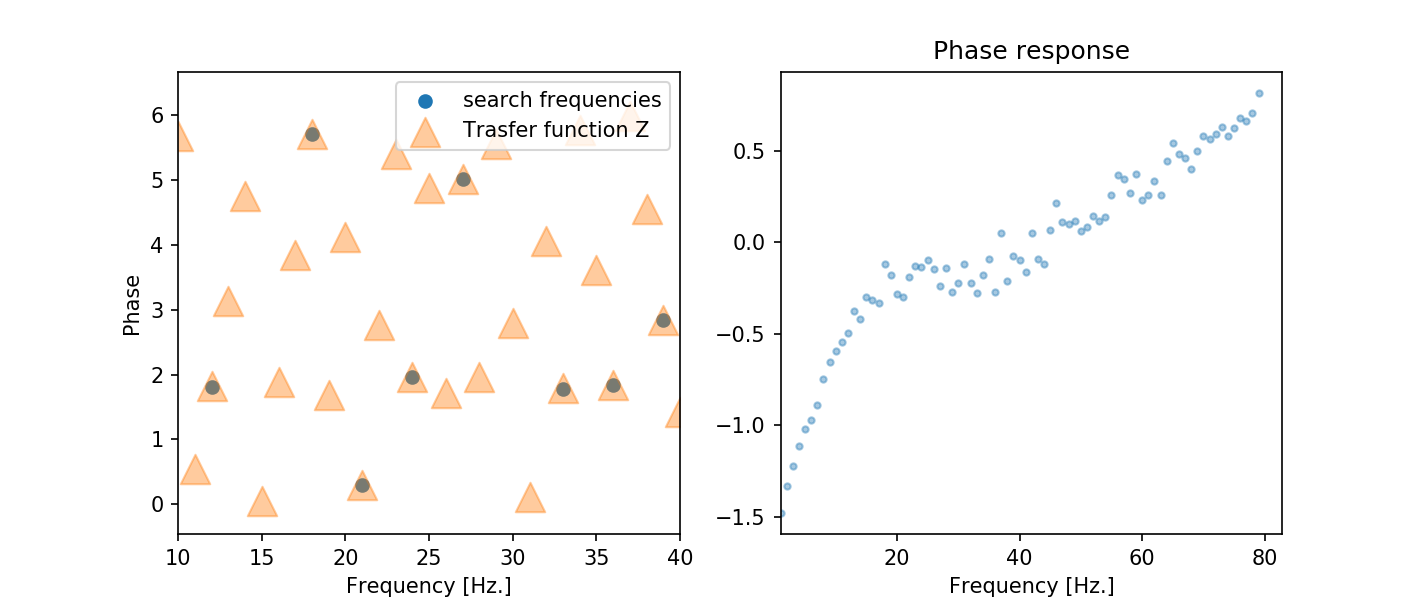

In [75]:
_,ax = plt.subplots(1,2,figsize=(9.5,4), sharex=False)
ax[0].scatter(freq_search, tf_phase, label='search frequencies')
ax[0].scatter(range(1,80), (np.array(tf_phase2)+np.pi/2)%(2*np.pi), alpha=0.4, s=200, marker='^', label='Trasfer function Z')
ax[1].plot(range(1,80), phases_diff2, '.', alpha=0.4 , label='tf e-field phases')
ax[0].set(xlim=(10,40), xlabel='Frequency [Hz.]', ylabel='Phase')
ax[1].set(xlim=(1,None), xlabel='Frequency [Hz.]', title='Phase response', ylim=(None,None))
ax[0].legend(loc='upper right')

In [51]:
np.array(tf_phase).shape, np.array(tf_phase3).shape

((79,), (79, 1))